In [158]:
import sys
import flower
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import deg_preserve_generator as gen
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [159]:
g = nx.read_edgelist('demograph.edgelist',nodetype=int)

In [204]:
layout = nx.spring_layout(g, k=0.1, iterations=1000)

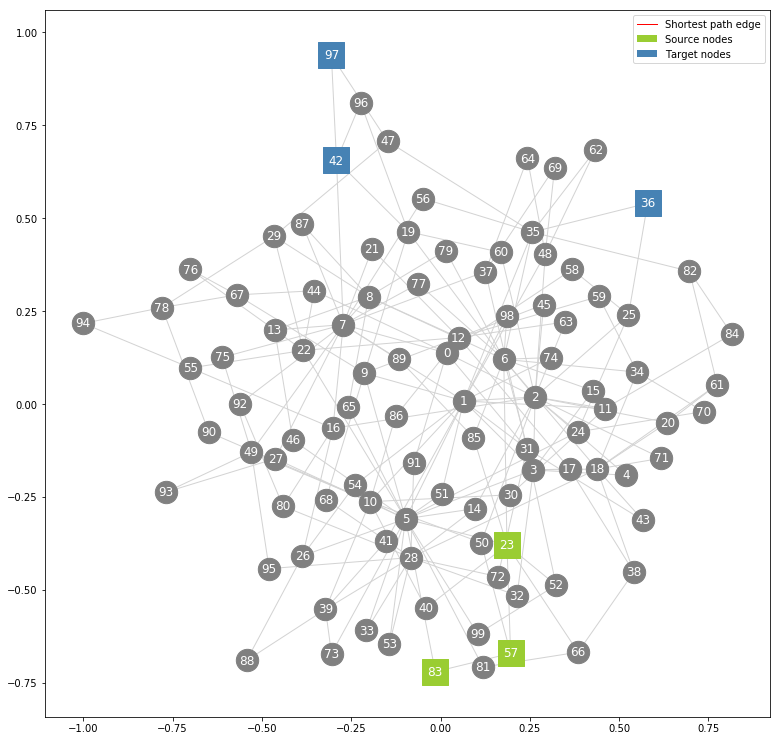

In [205]:
source = [83,57,23] # pick source and target nodes that are farthest apart for clearer results
target = [97,36,42]
plt.figure(figsize=[13,13])
nx.draw_networkx(g,layout, node_color='gray', node_size=500, edge_color='lightgray', font_color='white')
nx.draw_networkx_nodes(g, pos=layout, nodelist=source, node_size=700, node_shape='s', node_color='yellowgreen')
nx.draw_networkx_nodes(g, pos=layout, nodelist=target, node_size=700, node_shape='s', node_color='steelblue')
legend_elements = [Line2D([0], [0], color='red', lw=1, label='Shortest path edge'),
                   Patch(facecolor='yellowgreen', label='Source nodes'),
                   Patch(facecolor='steelblue', label='Target nodes')]
plt.gca().legend(handles=legend_elements, loc='upper right');

In [206]:
max_length = 10 # calculate paths up to the maximum length of max_length
# The iteration automatically stops if there are no path of lengths > max_length
# This is the most time-expensive operation of the algorithm, it may take a while...
spm = flower.calculate_spm_nx(g, max_length)

First iteration...
Paths calculation...


Execution finished earlier, all paths have been already calculated at maximum distance 6



In [207]:
spm.keys()

dict_keys(['num_paths', 'path_lengths', 'nodelist', 'deglist', 'curr_iter'])

In [208]:
fc = flower.eval_flow_centrality_nx(target,source,spm)

In [209]:
fcvals = np.asarray(fc.FC.values)

In [210]:
# just some code to highlight the shortest paths
src_tgt_sp = {}
for src in source:
    for tgt in target:
        paths = nx.all_shortest_paths(g, src,tgt)
        for path in paths:
            for i in range(len(path)-1):
                u,v = min(path[i],path[i+1]),max(path[i],path[i+1])
                if (u,v) in src_tgt_sp:
                    src_tgt_sp[(u,v)] += 1
                else:
                    src_tgt_sp[(u,v)] = 1

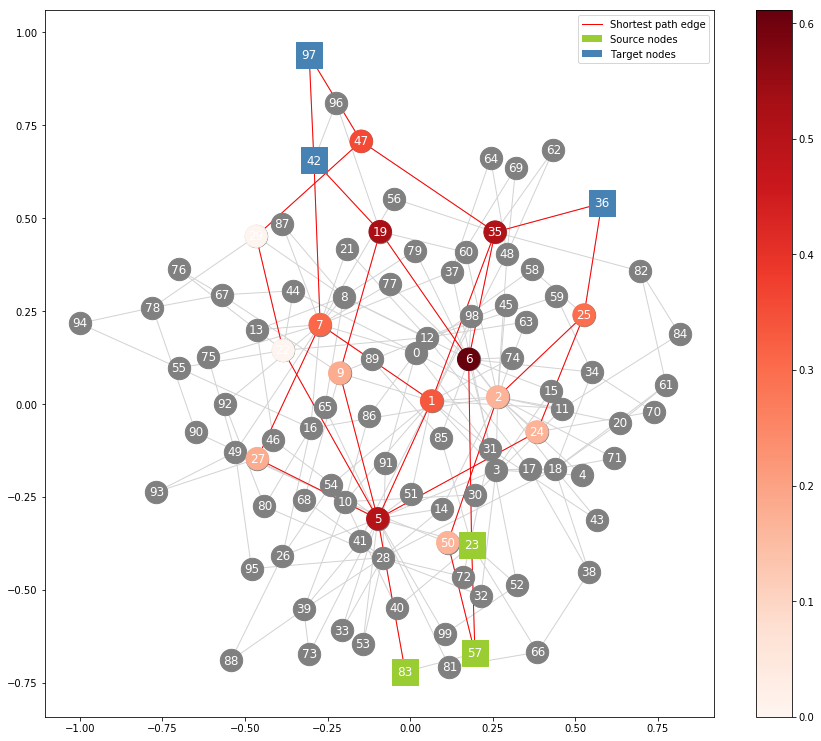

In [211]:

plt.figure(figsize=[15,13])
cmap = 'Reds'
nx.draw_networkx_nodes(g, pos=layout, nodelist=spm['nodelist'], node_size=500, node_color='gray')
nx.draw_networkx_nodes(g, pos=layout, nodelist=spm['nodelist'], node_size=500, node_color=np.log(fcvals), cmap=cmap)
nx.draw_networkx_nodes(g, pos=layout, nodelist=source, node_size=700, node_shape='s', node_color='yellowgreen')
nx.draw_networkx_nodes(g, pos=layout, nodelist=target, node_size=700, node_shape='s', node_color='steelblue')
nx.draw_networkx_edges(g, pos=layout, edge_color='lightgray')
nx.draw_networkx_edges(g, pos=layout, edgelist=src_tgt_sp.keys(), edge_color='red',width=1)
nx.draw_networkx_labels(g, layout, font_color='white')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=fcvals.min(), vmax=fcvals.max()))
sm._A = []
plt.colorbar(sm)
legend_elements = [Line2D([0], [0], color='red', lw=1, label='Shortest path edge'),
                   Patch(facecolor='yellowgreen', label='Source nodes'),
                   Patch(facecolor='steelblue', label='Target nodes')]
plt.gca().legend(handles=legend_elements, loc='upper right');

In [216]:
N_samples = 1000
rdm_source = gen.gen_degree_preserved_sets(source, g, N_samples, bin_minimum_occupancy=5)
rdm_target = gen.gen_degree_preserved_sets(target, g, N_samples, bin_minimum_occupancy=5)

In [221]:
fcs = flower.evaluate_fcs_nx(source, target, rdm_source, rdm_target, spm)

In [218]:
fctest = flower.eval_flow_centrality_nx(source,target, spm)
rdm_fcvals = np.zeros([len(g),len(rdm_source)])
for i,(src,tgt) in enumerate(zip(rdm_source,rdm_target)):
    rdm_fc = flower.eval_flow_centrality_nx(tgt,src,spm,progressbar=False)
    rdm_fcvals[:,i] = np.asarray(rdm_fc.FC.values)
fcstrue = flower.evaluate_flows_statistics_from_batch_nx(pd.DataFrame(rdm_fcvals,index=spm['nodelist']), fctest)

In [219]:
fcs = (fcvals - rdm_fcvals.mean(axis=1)) / rdm_fcvals.std(axis=1)
fcs[np.isnan(fcs) | np.isinf(fcs)] = 0 # we set nans and infs as 0 since they are given by these
                                        # situations where the average or std of the random samples is 0

In [247]:
fcsvals = fcs.loc[spm['nodelist']].FCS.values
#fcsvals = fcsvals-np.nanmin(fcsvals)+0.001

In [257]:
np.nanmin(np.log(fcvals[np.nonzero(fcvals)]))

-3.8066624897703196

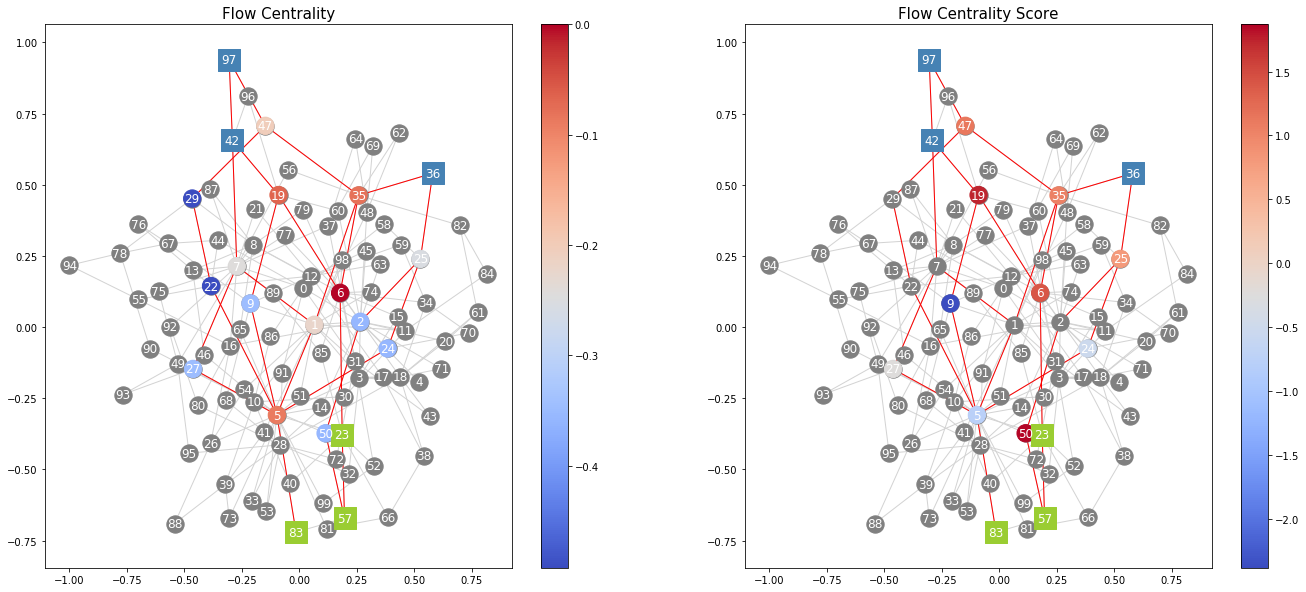

In [258]:
plt.figure(figsize=[23,10])
cmap = 'coolwarm'
plt.subplot(121)
nx.draw_networkx_nodes(g, pos=layout, nodelist=spm['nodelist'], node_size=300, node_color='gray')
nx.draw_networkx_nodes(g, pos=layout, nodelist=spm['nodelist'], node_size=300, node_color=np.log(fcvals), cmap=cmap)
nx.draw_networkx_nodes(g, pos=layout, nodelist=source, node_size=500, node_shape='s', node_color='yellowgreen')
nx.draw_networkx_nodes(g, pos=layout, nodelist=target, node_size=500, node_shape='s', node_color='steelblue')
nx.draw_networkx_edges(g, pos=layout, edge_color='lightgray')
nx.draw_networkx_edges(g, pos=layout, edgelist=src_tgt_sp.keys(), edge_color='red',width=1)
nx.draw_networkx_labels(g, layout, font_color='white')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=np.nanmax(np.log(fcvals))))
sm._A = []
plt.colorbar(sm)
plt.title('Flow Centrality',fontsize=15)
plt.subplot(122)
nx.draw_networkx_nodes(g, pos=layout, nodelist=spm['nodelist'], node_size=300, node_color='gray')
nx.draw_networkx_nodes(g, pos=layout, nodelist=spm['nodelist'], node_size=300, node_color=np.log(fcsvals), cmap=cmap)
nx.draw_networkx_nodes(g, pos=layout, nodelist=source, node_size=500, node_shape='s', node_color='yellowgreen')
nx.draw_networkx_nodes(g, pos=layout, nodelist=target, node_size=500, node_shape='s', node_color='steelblue')
nx.draw_networkx_edges(g, pos=layout, edge_color='lightgray')
nx.draw_networkx_edges(g, pos=layout, edgelist=src_tgt_sp.keys(), edge_color='red',width=1)
nx.draw_networkx_labels(g, layout, font_color='white')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = np.nanmin(np.log(fcsvals)), vmax=np.nanmax(np.log(fcsvals))))
sm._A = []
plt.colorbar(sm)
plt.title('Flow Centrality Score',fontsize=15);

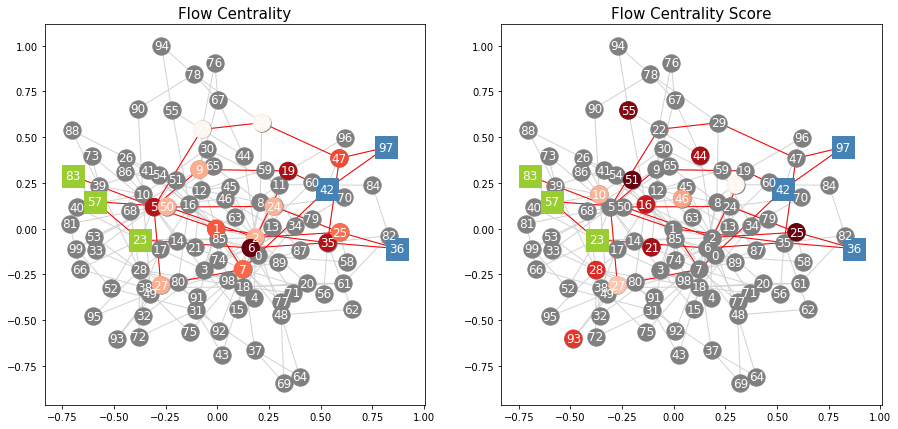

In [25]:
plt.figure(figsize=[15,7])
cmap = 'Reds'
plt.subplot(121)
nx.draw_networkx_nodes(g, pos=layout, nodelist=spm['nodelist'], node_size=300, node_color='gray')
nx.draw_networkx_nodes(g, pos=layout, nodelist=spm['nodelist'], node_size=300, node_color=np.log(fcvals), cmap=cmap)
nx.draw_networkx_nodes(g, pos=layout, nodelist=source, node_size=500, node_shape='s', node_color='yellowgreen')
nx.draw_networkx_nodes(g, pos=layout, nodelist=target, node_size=500, node_shape='s', node_color='steelblue')
nx.draw_networkx_edges(g, pos=layout, edge_color='lightgray')
nx.draw_networkx_edges(g, pos=layout, edgelist=src_tgt_sp.keys(), edge_color='red',width=1)
nx.draw_networkx_labels(g, layout, font_color='white')
plt.title('Flow Centrality',fontsize=15)
plt.subplot(122)
nx.draw_networkx_nodes(g, pos=layout, nodelist=spm['nodelist'], node_size=300, node_color='gray')
nx.draw_networkx_nodes(g, pos=layout, nodelist=spm['nodelist'], node_size=300, node_color=np.log(fcs), cmap=cmap)
nx.draw_networkx_nodes(g, pos=layout, nodelist=source, node_size=500, node_shape='s', node_color='yellowgreen')
nx.draw_networkx_nodes(g, pos=layout, nodelist=target, node_size=500, node_shape='s', node_color='steelblue')
nx.draw_networkx_edges(g, pos=layout, edge_color='lightgray')
nx.draw_networkx_edges(g, pos=layout, edgelist=src_tgt_sp.keys(), edge_color='red',width=1)
nx.draw_networkx_labels(g, layout, font_color='white')
plt.title('Flow Centrality Score',fontsize=15);

In [35]:
fcs.loc[55]

FCS                  5.09475
FC                  0.177778
mean              0.00986869
std                0.0329573
median                     0
one_tail_right             0
one_tail_left              1
degree                     4
in_src                 False
in_dest                False
Name: 55, dtype: object

In [119]:
imp.reload(flower)

<module 'flower' from '/Users/reema/Postdoc/Libs/MyPythonLibs3/Flower/flower.py'>

In [120]:
flower.evaluate_flows_statistics_nx(rdm_source,rdm_target,spm, true_flows=fc)

,fc,mean,std,median,one_tail_right,one_tail_left,zscore
nodename,,,,,,,
0,0.000000,0.021655,0.042966,0.000000,0.47,0.00,-0.504002
2,0.055556,0.235951,0.170925,0.207407,0.82,0.15,-1.055405
7,0.118519,0.131439,0.128773,0.103030,0.45,0.55,-0.100332
44,0.000000,0.003779,0.011260,0.000000,0.15,0.00,-0.335610
58,0.000000,0.000000,0.000000,0.000000,0.00,0.00,NaN
91,0.000000,0.007095,0.026443,0.000000,0.10,0.00,-0.268323
31,0.000000,0.043125,0.076231,0.000000,0.35,0.00,-0.565708
1,0.137037,0.134408,0.105069,0.111111,0.38,0.62,0.025020
51,0.000000,0.000000,0.000000,0.000000,0.00,0.00,NaN


In [29]:
fc.loc[spm['nodelist']]

,FC,FC_unnorm,N_paths
0,0.000000,0.000000,0.0
2,0.055556,0.500000,1.0
7,0.118519,1.066667,4.0
44,0.000000,0.000000,0.0
58,0.000000,0.000000,0.0
91,0.000000,0.000000,0.0
31,0.000000,0.000000,0.0
1,0.137037,1.233333,4.0
51,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0


In [30]:
fcs.loc[spm['nodelist']]

,FCS,FC,mean,std,median,one_tail_right,one_tail_left,degree,in_src,in_dest
0,-0.537304,0.000000,0.045870,0.085370,0.000000,0.43,0.00,6,False,False
2,-0.241175,0.118519,0.158742,0.166781,0.115741,0.50,0.50,16,False,False
7,-0.600581,0.137037,0.226446,0.148870,0.209259,0.68,0.32,15,False,False
44,3.854568,0.277778,0.028535,0.064662,0.000000,0.01,0.99,7,False,False
58,-0.349522,0.000000,0.019110,0.054673,0.000000,0.17,0.00,5,False,False
91,-0.171974,0.000000,0.000870,0.005061,0.000000,0.03,0.00,2,False,False
31,-0.236711,0.000000,0.001576,0.006659,0.000000,0.08,0.00,2,False,False
1,-0.840694,0.055556,0.195191,0.166095,0.170635,0.77,0.21,17,False,False
51,6.121821,0.392593,0.020103,0.060846,0.000000,0.00,1.00,5,False,False
3,-0.450305,0.000000,0.018984,0.042158,0.000000,0.32,0.00,3,False,False
